In [1]:
import pandas as pd
import numpy as np
from pynm.pynm import PyNM
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as sp

# **Complex Data**

In this tutorial we'll look at using the Generalized Additive Models of Location Scale and Shape (GAMLSS) to model complex data that aren't suitable for the Centiles, LOESS or GP models.

## **GAMLSS**
Generalized Additive Models of Location Scale and Shape (GAMLSS) are an extension of Generalized Additive Models (GAM), which are an extension of generalized linear models. The most important feature of the GAMLSS is that they can be used to model multi-parameter distributions, meaning we can specify models for each of location, scale, shape and skewness. This flexibility allows the GAMLSS to overcome the homoskedasticity and gaussian noise asusmptions of the GP & SVGP models. However, GAMLSS are advanced statistical models that require good design choices in order to produce reliable results i.e. they should not be used with off the shelf defaults. 

In this tutorial we will implement the recommendations of the Dinga et al. 2021 [preprint](https://doi.org/10.1101/2021.06.14.448106), which we consider required reading for normative modeling with GAMLSS.


## **Example 1**
First we'll revisit the dataset from the previous tutorial to illustrate how the GAMLSS deals with heteroskedasticity compared to the GP model.

Here we are using a dataset with:
- A single explanatory variable (age)
- Heteroskedastic variance across the explanatory variable
- Non-gaussian noise
- A random offset in score for probands pulled from the gaussian distribution

In [2]:
# Define functions
def sample_x(low=1,high=100,n_subs=1000,sampling='full'):
    if sampling =='full':
        x = np.random.uniform(low=low,high=high,size=n_subs)
    else:
        x = np.concatenate([np.random.normal(20,10,size=int(n_subs/2)),np.random.normal(80,10,size=int(n_subs/2))])
        x = x[(x<high) & (x > low)]
    return x

def hetero_sin_noise(x):
    return 3*np.sin(0.05*x)*np.random.randn() + sp.skewnorm.rvs(a=2,size=1)[0]

def dataset_heteroskedastic(low=1,high=100,n_subs=1000,sampling='full',seed=888):
    np.random.seed(seed)
    x = sample_x(low=low,high=high,n_subs=n_subs,sampling=sampling)

    # PROB = 1/CTR = 0
    status = np.random.binomial(1,0.07,size=x.shape[0])

    # Score param
    score = np.zeros(x.shape[0])
    for i in range(x.shape[0]):
        s = 5 + hetero_sin_noise(x[i])

        # Random offset for probands
        s = s + status[i]*np.random.normal(0.7,1)

        score[i] = s

    df = pd.DataFrame([x,score,status],index=['x','score','status']).transpose()
    return df

In [3]:
# Create a dataset
df_het = dataset_heteroskedastic()
df_het.head()

,x,score,status
0,86.096500,6.546667,0.0
1,17.292380,4.395376,1.0
2,48.864120,4.275272,0.0
3,92.181699,4.362332,1.0
4,43.427088,6.529171,0.0


### Visualize data

<AxesSubplot:xlabel='x', ylabel='score'>

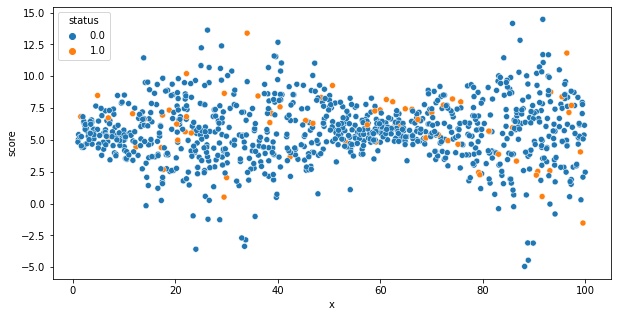

In [4]:
plt.figure(figsize=(10,5))
sns.scatterplot(x='x',y='score',hue='status',data=df_het)

### Fit GAMLSS model on heteroskedastic data

In [5]:
# Initialize pynm w/ data, confounds, & bin parameters
m_het = PyNM(df_het,'score','status',['x'],
                bin_width=7, bin_spacing=1)

Models will be fit on full set of controls.


In [49]:
# Run models
m_het.loess_normative_model()
#m_het.gp_normative_model(length_scale_bounds='fixed',length_scale=20)
m_het.gamlss_normative_model(mu = "score ~ cs(x)",
                            sigma = "~ cs(x,df=2)",
                            family='NO2')

GAMLSS-RS iteration 1: Global Deviance = 4074.972 
GAMLSS-RS iteration 2: Global Deviance = 4074.981 
GAMLSS-RS iteration 3: Global Deviance = 4074.983 
GAMLSS-RS iteration 4: Global Deviance = 4074.971 
GAMLSS-RS iteration 5: Global Deviance = 4074.97 
GAMLSS-RS iteration 6: Global Deviance = 4074.97 
new prediction 
new prediction 


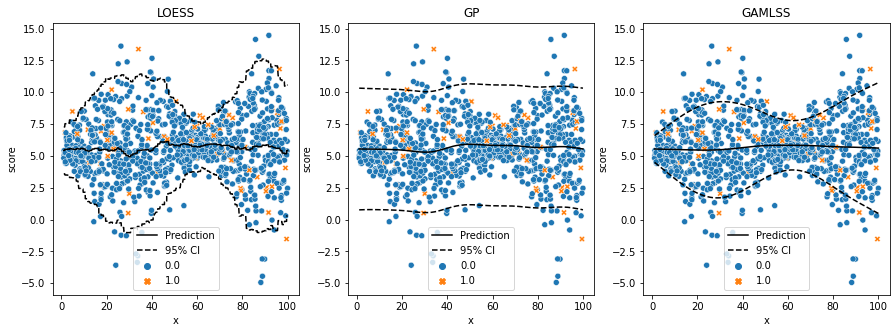

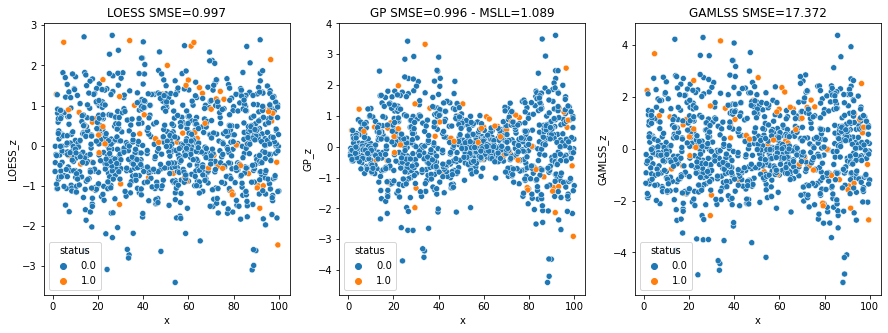

In [50]:
# Plot the data, model prediction, & 95% confidence interval
m_het.plot()

# Plot the z-scores of the model (model residuals / std deviation)
m_het.plot_z(confound='x')